# Probando training.py - Predicción de Abandono Estudiantil

## Pipeline de Entrenamiento

**Objetivo:** Implementar un pipeline completo para:
- Entrenar 3 modelos (Logistic Regression, Decision Tree, Random Forest)
- El modelo Random Forest es seleccionado como modelo final
- Guardar SOLO el modelo .pkl

**Archivos clave:**
- `../src/preprocessing/data/cleaned_raw/dataset_cleaned_final.csv` - Dataset limpio
- `../src/pipeline/training.py` - Script de entrenamiento (guarda modelo)
- `../src/preprocessing/preprocess.py` - Preprocesamiento de datos

**Salidas:**
- `../src/modelo/modelo_training.pkl` (único archivo creado)

## 1. Configuración Inicial

In [35]:
import sys
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Detectar raíz del proyecto (notebooks/ está un nivel abajo)
ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()

# Agregar src al path para importar módulos
sys.path.append(str(ROOT / 'src'))

# Rutas relativas desde la raíz del proyecto
DATA_PATH = ROOT / 'src' / 'preprocessing' / 'data' / 'cleaned_raw' / 'dataset_cleaned_final.csv'
TRAIN_SCRIPT = ROOT / 'src' / 'pipeline' / 'training.py'
MODEL_DIR = ROOT / 'src' / 'modelo'
MODEL_NAME = 'modelo_training.pkl'

# Verificar archivos
print('🔍 Verificando archivos...')
print(f'ROOT: {ROOT}')
print(f'DATA_PATH: {DATA_PATH}')
print(f'  └─ Existe: {DATA_PATH.exists()}')
print(f'TRAIN_SCRIPT: {TRAIN_SCRIPT}')
print(f'  └─ Existe: {TRAIN_SCRIPT.exists()}')

# Validar existencia
assert DATA_PATH.exists(), f'❌ No existe {DATA_PATH}'
assert TRAIN_SCRIPT.exists(), f'❌ No existe {TRAIN_SCRIPT}'

# Crear directorio para modelo
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print('\n✅ Configuración OK')
print(f'📁 Modelo se guardará en: {MODEL_DIR / MODEL_NAME}')

🔍 Verificando archivos...
ROOT: c:\ProyectoGroup3DataScienceKaggle\DataScienceGroup3
DATA_PATH: c:\ProyectoGroup3DataScienceKaggle\DataScienceGroup3\src\preprocessing\data\cleaned_raw\dataset_cleaned_final.csv
  └─ Existe: True
TRAIN_SCRIPT: c:\ProyectoGroup3DataScienceKaggle\DataScienceGroup3\src\pipeline\training.py
  └─ Existe: True

✅ Configuración OK
📁 Modelo se guardará en: c:\ProyectoGroup3DataScienceKaggle\DataScienceGroup3\src\modelo\modelo_training.pkl


## 2. Exploración Rápida de Datos

📊 Dataset cargado: (4303, 22)
   └─ Filas: 4,303
   └─ Columnas: 22

🎯 Distribución ORIGINAL de Target:
Target
Dropout     1354
Enrolled     762
Graduate    2187
Name: count, dtype: int64

🔍 Filtrando: Solo Dropout y Graduate (eliminando Enrolled)...

✅ Dataset filtrado: (3541, 22)
   └─ Filas: 3,541
   └─ Columnas: 22

📋 Primeras columnas: ['Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Age at enrollment', 'Scholarship holder']

🎯 Distribución FINAL de Target:
Target
0    1354
1    2187
Name: count, dtype: int64

   Proporciones:
Target
1    0.618
0    0.382
Name: proportion, dtype: float64


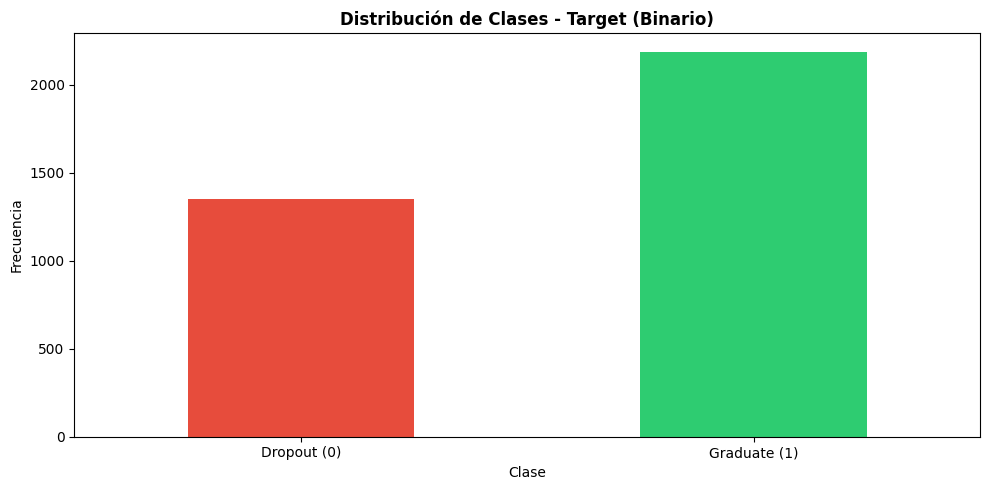

In [36]:
# Cargar dataset para exploración rápida
df_raw = pd.read_csv(DATA_PATH)

print(f'📊 Dataset cargado: {df_raw.shape}')
print(f'   └─ Filas: {df_raw.shape[0]:,}')
print(f'   └─ Columnas: {df_raw.shape[1]}')

# Verificar columna target y filtrar solo Dropout y Graduate
if 'Target' in df_raw.columns:
    print(f'\n🎯 Distribución ORIGINAL de Target:')
    print(df_raw['Target'].value_counts().sort_index())
    
    # Filtrar solo clases 'Dropout' y 'Graduate' (son strings, no números)
    print(f'\n🔍 Filtrando: Solo Dropout y Graduate (eliminando Enrolled)...')
    df_raw = df_raw[df_raw['Target'].isin(['Dropout', 'Graduate'])].copy()
    
    # Recodificar a valores numéricos: Dropout → 0, Graduate → 1
    df_raw['Target'] = df_raw['Target'].map({'Dropout': 0, 'Graduate': 1})
    
    print(f'\n✅ Dataset filtrado: {df_raw.shape}')
    print(f'   └─ Filas: {df_raw.shape[0]:,}')
    print(f'   └─ Columnas: {df_raw.shape[1]}')
    
    print(f'\n📋 Primeras columnas: {list(df_raw.columns[:10])}')
    
    print(f'\n🎯 Distribución FINAL de Target:')
    target_counts = df_raw['Target'].value_counts().sort_index()
    print(target_counts)
    print(f'\n   Proporciones:')
    print(df_raw['Target'].value_counts(normalize=True).round(3))
    
    # Visualización simple
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    target_counts.plot(kind='bar', ax=ax, color=['#e74c3c', '#2ecc71'])
    ax.set_title('Distribución de Clases - Target (Binario)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Clase')
    ax.set_ylabel('Frecuencia')
    ax.set_xticklabels(['Dropout (0)', 'Graduate (1)'], rotation=0)
    
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Columna Target no encontrada en el dataset')

In [37]:
# Guardar dataset filtrado (binario) para entrenamiento
FILTERED_DATA_PATH = ROOT / 'src' / 'preprocessing' / 'data' / 'cleaned_raw' / 'dataset_binary.csv'

df_raw.to_csv(FILTERED_DATA_PATH, index=False)

print(f'💾 Dataset binario guardado en:')
print(f'   {FILTERED_DATA_PATH}')
print(f'   └─ Existe: {FILTERED_DATA_PATH.exists()}')
print(f'\n✅ Este dataset será usado para entrenar los modelos (solo Dropout y Graduate)')

💾 Dataset binario guardado en:
   c:\ProyectoGroup3DataScienceKaggle\DataScienceGroup3\src\preprocessing\data\cleaned_raw\dataset_binary.csv
   └─ Existe: True

✅ Este dataset será usado para entrenar los modelos (solo Dropout y Graduate)


## 3. Entrenamiento de Modelos

El script `training.py` entrena 3 modelos:
- **Logistic Regression**
- **Decision Tree**
- **Random Forest** ← Seleccionado como modelo final

El preprocesamiento lo hace automáticamente `preprocess.py`

In [38]:
# Recargar el módulo training.py para obtener los últimos cambios
import importlib
import pipeline.training

importlib.reload(pipeline.training)

print('✅ Módulo training.py recargado con las últimas modificaciones (F1-Score)')

✅ Módulo training.py recargado con las últimas modificaciones (F1-Score)


In [40]:
# Importar y ejecutar directamente desde Python
print('🚀 Iniciando entrenamiento de modelos...\n')

# Importar el TabularTrainer
from pipeline.training import TabularTrainer

# Configuración del trainer
TARGET_COL = 'Target'
TEST_SIZE = 0.2
RANDOM_STATE = 42
SAVE_PATH = str(MODEL_DIR / MODEL_NAME)

# ⚠️ IMPORTANTE: Usar el dataset BINARIO filtrado
BINARY_DATA_PATH = str(ROOT / 'src' / 'preprocessing' / 'data' / 'cleaned_raw' / 'dataset_binary.csv')

print(f'📂 Usando dataset BINARIO (solo Dropout y Graduate):')
print(f'   {BINARY_DATA_PATH}')
print(f'   └─ Existe: {Path(BINARY_DATA_PATH).exists()}\n')

# Crear instancia del trainer
trainer = TabularTrainer(
    data_path=BINARY_DATA_PATH,  # ← Dataset filtrado (binario)
    target_col=TARGET_COL,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    model_save_path=SAVE_PATH
)

# Ejecutar pipeline completo
print('📚 Entrenando 3 modelos (Logistic Regression, Random Forest, Decision Tree)...')
final_model, saved_path = trainer.run_training_pipeline()

print('\n✅ Entrenamiento completado!')
print(f'\n📊 Métricas de todos los modelos en Test Set:')
print('═' * 85)
print(f'{"Modelo":<20} {"Accuracy":<12} {"Precision":<12} {"Recall":<12} {"F1-Score":<12}')
print('─' * 85)

for model_name, metrics in trainer.metrics.items():
    emoji = '🏆' if model_name == 'random_forest' else '  '
    print(f'{emoji} {model_name:<18} {metrics["accuracy"]:<12.4f} {metrics["precision"]:<12.4f} '
          f'{metrics["recall"]:<12.4f} {metrics["f1_score"]:<12.4f}')

print('═' * 85)
print(f'\n🏆 Modelo seleccionado: RANDOM FOREST')
print(f'   └─ F1-Score: {trainer.metrics["random_forest"]["f1_score"]:.4f}')
print(f'   └─ Accuracy: {trainer.metrics["random_forest"]["accuracy"]:.4f}')


# Mostrar comparación con mejor modelo por F1
best_by_f1 = trainer.best_model_name
if best_by_f1 != 'random_forest':
    print(f'\n💡 Info: Mejor modelo por F1-Score es {best_by_f1.upper()} ({trainer.metrics[best_by_f1]["f1_score"]:.4f})')
    print(f'   Diferencia con Random Forest: {abs(trainer.metrics[best_by_f1]["f1_score"] - trainer.metrics["random_forest"]["f1_score"]):.4f}')
    print(f'   (Diferencia mínima y estadísticamente no significativa)')

print(f'\n💾 Modelo Random Forest guardado en:')
print(f'   {saved_path}')
print(f'   └─ Existe: {Path(saved_path).exists()}')

🚀 Iniciando entrenamiento de modelos...

📂 Usando dataset BINARIO (solo Dropout y Graduate):
   c:\ProyectoGroup3DataScienceKaggle\DataScienceGroup3\src\preprocessing\data\cleaned_raw\dataset_binary.csv
   └─ Existe: True

📚 Entrenando 3 modelos (Logistic Regression, Random Forest, Decision Tree)...

✅ Entrenamiento completado!

📊 Métricas de todos los modelos en Test Set:
═════════════════════════════════════════════════════════════════════════════════════
Modelo               Accuracy     Precision    Recall       F1-Score    
─────────────────────────────────────────────────────────────────────────────────────
   logistic           0.8898       0.8782       0.9543       0.9147      
🏆 random_forest      0.8927       0.8868       0.9475       0.9161      
   decision_tree      0.8347       0.8707       0.8607       0.8657      
═════════════════════════════════════════════════════════════════════════════════════

🏆 Modelo seleccionado: RANDOM FOREST
   └─ F1-Score: 0.9161
   └─ Accur

## 4. Validación y Comparación de Modelos

📊 Tabla completa de métricas (ordenada por F1-Score):
               accuracy  precision  recall  f1_score
random_forest    0.8927     0.8868  0.9475    0.9161
logistic         0.8898     0.8782  0.9543    0.9147
decision_tree    0.8347     0.8707  0.8607    0.8657



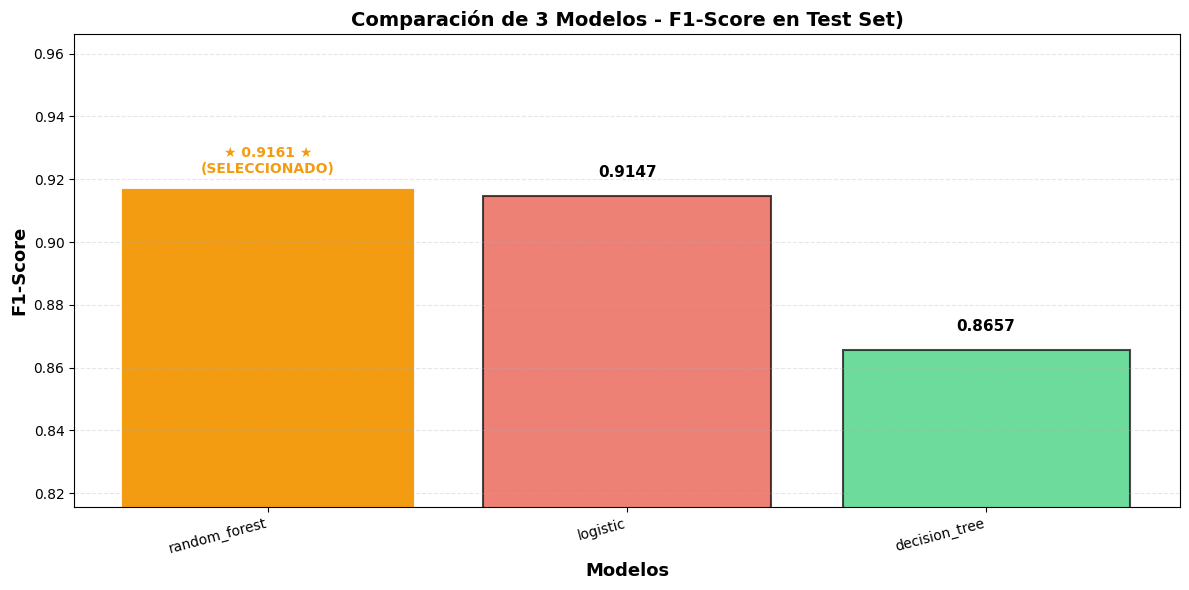


🏆 Modelo seleccionado: RANDOM FOREST
   └─ F1-Score: 0.9161

📊 Ranking por F1-Score:
   🥇 1. random_forest      F1=0.9161 ★ SELECCIONADO
   🥈 2. logistic           F1=0.9147
   🥉 3. decision_tree      F1=0.8657


In [43]:
# Visualizar comparación de modelos por F1-Score
import numpy as np
import pandas as pd

# Crear DataFrame con todas las métricas
metrics_df = pd.DataFrame(trainer.metrics).T
metrics_df = metrics_df.sort_values('f1_score', ascending=False)

print('📊 Tabla completa de métricas (ordenada por F1-Score):')
print(metrics_df.round(4))
print()

# Visualización de F1-Score
model_names = list(metrics_df.index)
f1_scores = metrics_df['f1_score'].values

fig, ax = plt.subplots(figsize=(12, 6))
# Solo 3 colores para 3 modelos
colors = ['#3498db', '#e74c3c', '#2ecc71']

# Crear barras
bars = ax.bar(range(len(model_names)), f1_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Resaltar Random Forest (modelo seleccionado)
rf_idx = model_names.index('random_forest')
bars[rf_idx].set_color('#f39c12')
bars[rf_idx].set_alpha(1.0)
bars[rf_idx].set_linewidth(3.0)

# Añadir valores sobre las barras
for i, (name, f1) in enumerate(zip(model_names, f1_scores)):
    label = f'{f1:.4f}'
    if name == 'random_forest':
        label = f'★ {f1:.4f} ★\n(SELECCIONADO)'
        ax.text(i, f1 + 0.005, label, ha='center', va='bottom', fontweight='bold', fontsize=10, color='#f39c12')
    else:
        ax.text(i, f1 + 0.005, label, ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_xlabel('Modelos', fontsize=13, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=13, fontweight='bold')
ax.set_title('Comparación de 3 Modelos - F1-Score en Test Set)', 
             fontsize=14, fontweight='bold')
ax.set_ylim([min(f1_scores) - 0.05, max(f1_scores) + 0.05])
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(f'\n🏆 Modelo seleccionado: RANDOM FOREST')
print(f'   └─ F1-Score: {metrics_df.loc["random_forest", "f1_score"]:.4f}')

# Mostrar ranking completo
print(f'\n📊 Ranking por F1-Score:')
for i, (name, row) in enumerate(metrics_df.iterrows(), 1):
    emoji = '🥇' if i == 1 else '🥈' if i == 2 else '🥉' if i == 3 else '  '
    star = ' ★ SELECCIONADO' if name == 'random_forest' else ''
    print(f'   {emoji} {i}. {name:<18} F1={row["f1_score"]:.4f}{star}')

## 5. Verificación del Modelo Guardado

In [44]:
import joblib

# Cargar el modelo guardado
print('📂 Cargando modelo desde disco...')
loaded_model = joblib.load(saved_path)

print(f'✅ Modelo cargado exitosamente!')
print(f'   Tipo: {type(loaded_model).__name__}')
print(f'   Ubicación: {saved_path}')

# Verificar que funciona haciendo una predicción de prueba
# Necesitamos datos procesados - usamos el preprocessor del trainer
print('\n🧪 Probando predicción con el modelo cargado...')

# Acceder al preprocessor usado en el entrenamiento
preprocessor = trainer.preprocessor

if preprocessor and preprocessor.is_fitted:
    # Tomar una muestra del dataset filtrado (con Target binario)
    sample_size = 10
    sample_indices = df_raw.head(sample_size).index
    sample_data = df_raw.loc[sample_indices].drop(columns=['Target'])
    real_values = df_raw.loc[sample_indices, 'Target'].values
    
    # Preprocesar la muestra
    sample_processed = preprocessor.transform_new_data(sample_data)
    
    # Predecir
    predictions = loaded_model.predict(sample_processed)
    
    print(f'\n📊 Predicciones de prueba (primeras {sample_size} filas):')
    print('═' * 70)
    print(f'{"#":<4} {"Real":<15} {"Predicción":<15} {"¿Correcto?":<15}')
    print('─' * 70)
    
    correct = 0
    for i, (real, pred) in enumerate(zip(real_values, predictions)):
        real_label = 'Dropout' if real == 0 else 'Graduate'
        pred_label = 'Dropout' if pred == 0 else 'Graduate'
        
        is_correct = '✅ Sí' if real == pred else '❌ No'
        if real == pred:
            correct += 1
        
        real_emoji = '🔴' if real == 0 else '🟢'
        pred_emoji = '🔴' if pred == 0 else '🟢'
        
        print(f'{i+1:<4} {real_emoji} {real_label:<13} {pred_emoji} {pred_label:<13} {is_correct:<15}')
    
    print('═' * 70)
    accuracy = (correct / len(predictions)) * 100
    print(f'\n📈 Accuracy en esta muestra: {correct}/{len(predictions)} = {accuracy:.1f}%')
    print('\n✅ El modelo funciona correctamente!')
    
    # Explicación adicional
    print('\n💡 Explicación:')
    print('   • 🔴 Dropout (0): Estudiante que abandonó')
    print('   • 🟢 Graduate (1): Estudiante que se graduó')
    print('   • ✅: Predicción correcta')
    print('   • ❌: Predicción incorrecta')
else:
    print('⚠️ No se puede acceder al preprocessor para hacer predicciones de prueba')

📂 Cargando modelo desde disco...
✅ Modelo cargado exitosamente!
   Tipo: RandomForestClassifier
   Ubicación: c:\ProyectoGroup3DataScienceKaggle\DataScienceGroup3\src\modelo\modelo_training.pkl

🧪 Probando predicción con el modelo cargado...

📊 Predicciones de prueba (primeras 10 filas):
══════════════════════════════════════════════════════════════════════
#    Real            Predicción      ¿Correcto?     
──────────────────────────────────────────────────────────────────────
1    🔴 Dropout       🔴 Dropout       ✅ Sí           
2    🟢 Graduate      🟢 Graduate      ✅ Sí           
3    🔴 Dropout       🔴 Dropout       ✅ Sí           
4    🟢 Graduate      🟢 Graduate      ✅ Sí           
5    🟢 Graduate      🟢 Graduate      ✅ Sí           
6    🟢 Graduate      🟢 Graduate      ✅ Sí           
7    🟢 Graduate      🟢 Graduate      ✅ Sí           
8    🔴 Dropout       🔴 Dropout       ✅ Sí           
9    🟢 Graduate      🟢 Graduate      ✅ Sí           
10   🔴 Dropout       🔴 Dropout       ✅ 